# CSE527 Homework 3 - Part 2
**Due date: 23:59 on Nov 10, 2024**


## Description
---
Detection is a fundamental task in CV. This homework is on based on DETR (https://arxiv.org/abs/2005.12872), one of the most famous yet simple detection model.

In this part, you will get familiar with DETR code base and will be modfiying the code (https://github.com/facebookresearch/detr/tree/main) to perfrom a new task: **_Detection using Centroids_**.

Traditionally bounding boxes are used to highlight detections, however in this homework you will perfrom detection of an object by selecting a _meaningful_ center point on it. We will call that point the centroid. For applications involving peculiar objects (like Giraffes,), where the center of the bounding box may not lie on the objects main body, a centroid detection may be more useful.    
  





## Code
---
Although DETR is simple relative to other detection models, the code to train and test is still complex and is spread acorss multiple directories. For this reason, the code is provided in a zipped package (here [detr.zip](https://drive.google.com/file/d/1GuserI8EDxAlTG4eh98JhugVsSDWCS3f/view?usp=sharing)).

To pull this code into your colab, you have to first add the zip file as shortcut to current working directory. To do this, open the above link and click on "Add shortcut to Drive" button (drive symbol with a plus) and navigate to working current directory and add shortcut.

You have to repeat the same process to download this [coco.zip dataset](https://drive.google.com/file/d/1GVyxYHwVgiG9z_Sn46wslT_2n65DLZRw/view?usp=sharing).

In [65]:
HW3_ROOT_PATH = 'hw3/'
PATH_TO_PART2 = HW3_ROOT_PATH + 'part2/'
PATH_TO_COCO = HW3_ROOT_PATH + 'coco/'
# TRY to use these variable wherever you load/save some file

In [67]:
!ls

CSE527_24F_HW3_P2.ipynb  detr  detr.zip


In [69]:
%cd detr
%mkdir checkpoints

/gdrive/.shortcut-targets-by-id/1bE0lnMcU5RVsE1jbQeewCCLiA3JIkFL2/CSE527 Assignments/Murugan_Vijayabharathi_116745378_hw3/part2/detr
mkdir: cannot create directory ‘checkpoints’: File exists


## Install dependencies
---
If you are using colab, running below cell will suffice, else refer to requirements.txt to install all dependencies

In [70]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lju9ku1r
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lju9ku1r
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


##Model
---
DETR consists of
- a feature extractor,
- transformer and
- two output heads
    - classification head
    - regression head

In the original implementation, regression head is designed to output the bouding box attributes ltrb (left, top, right, & bottom edges of object). In this homework we intend to train the model to output the centeroids of each object.

###How do we define centroids:###
Original DETR uses the MS COCO's _bbox_ annotations to train the model, while in this HW we will use the _segmentation_ annotations.
Each image may have multiple objects. The pixel outline of each object is provided as an annotation. We will use this contour information to generate the object mask.


In the below image, you can see that centroid is near the biggest portion of the object body.  
![](https://drive.google.com/uc?export=view&id=1CNym_GFV8EKwTQPZQSHZdPB7P-3qarEm)




## Get yourself familiar with Dataset
---

To get your self familiar with the dataset, you are encouraged to play around with the COCO API. The sample code  given below displays the segmentation data format. In the later sections you will be yusing the segmentation data to estimate a centroid.  

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Image keys: dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
Anno segmentation: [[318.97, 254.35, 328.71, 199.41, 339.35, 164.86, 343.78, 154.23, 336.69, 135.62, 349.09, 145.37, 365.93, 145.37, 372.13, 137.39, 380.1, 145.37, 397.82, 146.25, 436.81, 148.02, 472.25, 159.54, 506.8, 175.49, 536.93, 188.78, 579.46, 202.07, 617.56, 205.62, 640.0, 199.41, 637.94, 349.15, 590.09, 351.81, 547.56, 334.98, 501.49, 317.25, 511.23, 349.15, 510.35, 376.62, 516.55, 407.63, 505.03, 407.63, 498.83, 381.93, 497.94, 407.63, 480.22, 405.86, 474.02, 367.76, 459.85, 316.37, 437.69, 284.47, 432.38, 257.89, 412.89, 230.42, 391.62, 210.05, 380.1, 222.45, 363.27, 233.97, 357.95, 251.69, 346.43, 259.66, 330.49, 264.98]]
496870


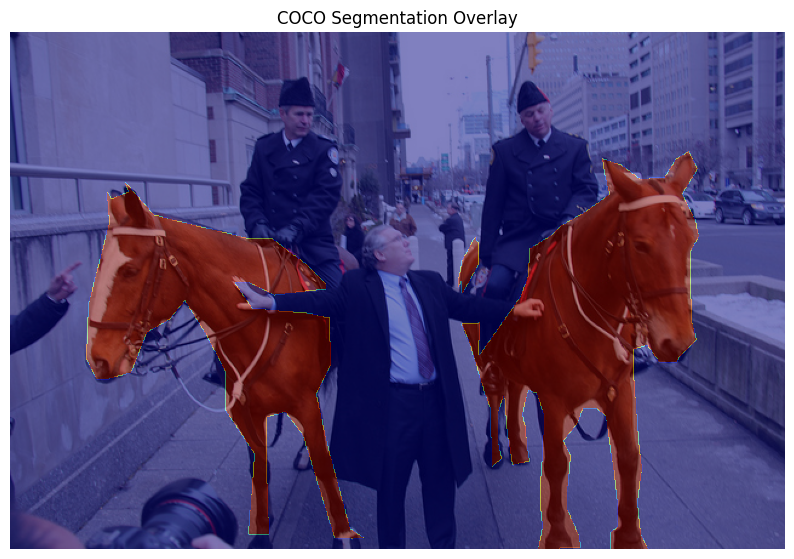

In [71]:
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from hubconf import _make_detr
import torch
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T

coco = COCO('instances_train2017.json')
ids = coco.getImgIds()
sample = 0
im = coco.loadImgs(ids[sample])[0]
print(f'Image keys: {im.keys()}')
annos = coco.loadAnns(coco.getAnnIds(ids[sample]))
# Note: segmentation annotation is in the format of [x1, y1, x2, y2, x3, y3, . . . ], where (x1, y1) is a point
# on countour, x being dist from left and y is dist from top row of image
print(f'Anno segmentation: {(annos[0]["segmentation"])}')
############# (0 points) ########################


paths = [os.path.join(PATH_TO_COCO, "train2017", i) for i in os.listdir(PATH_TO_COCO + "train2017")]
path = paths[15]
id = int(path.split("/")[-1].split(".")[0])
print(id)

image = Image.open(path).convert("RGB")
image_np = np.array(image)

annotation_ids = coco.getAnnIds(imgIds=id)
annotations = coco.loadAnns(annotation_ids)

info = coco.loadImgs(id)[0]

mask = Image.new('L', (info['width'], info['height']), 0)

for ann in annotations:
    if 'segmentation' in ann:
        for segmentation in ann['segmentation']:
            poly = np.array(segmentation).reshape(-1, 2).astype(int)
            ImageDraw.Draw(mask).polygon(list(map(tuple, poly)), outline=1, fill=1)

for ann in annotations:
    if 'segmentation' in ann:
        for segmentation in ann['segmentation']:
            poly = np.array(segmentation).reshape(-1, 2).astype(int)
            ImageDraw.Draw(mask).polygon(list(map(tuple, poly)), outline=1, fill=1)

plt.figure(figsize=(10, 10))
plt.imshow(image_np)  # Display the original image
plt.imshow(mask, alpha=0.5, cmap='jet')  # Overlay the mask
plt.axis('off')
plt.title('COCO Segmentation Overlay')
plt.show()


#################################################


## Complete the code
---

This provided detr/ folder has the following structure
```
detr/
├── datasets/
│   ├── coco.py
│   ├── ...
├── models/
│   ├── detr.py
│   ├── matcher.py
│   └── ...
├── utils/
│   └── ...
├── engine.py
├── main.py
├── requirements.txt
└── README.md
```

In these python files, you will be implementing the missing code blocks. These blocks are highlited by the TODOs
```#### TODO CSE527 STUDENT CODE STARTS HERE ######```


In total there are 5 sections the code has to be filled. They are located in the files: coco.py, detr.py, matcher.py.  

To complete this part you are very much encouraged to:
- understand how dataset, data sampler, dataloader, model, loss, & optimizer work together during training  
- refer to the actual DETR implementation at [git:facebookresearch/detr](https://github.com/facebookresearch/detr/tree/main) to get an idea of the training pipeline.
- try to understand flow of control from main.py.

You cannot complete the missing code blocks just from the given description in this ipynb, so you must read the code around. That is, you will read the inputs, outputs and how the inputs to the code block are created and how the outputs from the code block will be utilized.   

## Task
You should modify the DETR to output centroids rather than bounding boxes.   
Dataset:
At the dataset level, you are not actually given the centroids, so you will use the instance segmentation masks to estimage the centroid for each object in annotation.

Model:
For this you will need to replace the classification and regression heads (already removed in the code provided to you, you just need to add new).



### 1 - coco.py: `ConvertCocoPolysToMask.__call__()`  [20 points]
Here you will be writing the logic to convert annotations to centroids in the following method.
Note: You will have to figure out the inputs and outputs by yourself.  
```
def convert_coco_poly_to_centroids(segmentations, h, w, boxes) -> Torch.Tensor(shape = num_segmentations x 2)
```

This method is part of data loader, and is called when generating the <sample, prediction> pairs, which will eventually be passed onto model for training.

The _centroid_ we are referring to is a hypothetical point on the center of the object's main body part. It should ideally never be a point outside the annotation mask, and is likley always in the middle of body. Here in our case centroid should lie on the middle of horse's torso.

steps:
 - convert segmentations into masks [5 points]
 - figure out a way to remove thin sections of object (legs and tail of the horse) from the mask, so only the largest body part (torso) will influence the centroid [10 points]
 - compute the center of mass of the mask [5 point]

 Feel free to pass on more inputs/outputs to the above method to support your way of computing centroids.


### 2 & 3 - detr.py: `DETR.__init__()`, `DETR.forward()` [10 + 15 points]

This is the DETR model architectrure. Here you will change the classification and regression heads, so the model can output centroids (unlike bboxes in original implementation).
Also you will write logic to freeze the remaining section of DETR.

Original model takes 300 hours to completely train from scrtch, so it is important to freeze all weights except necessary ones (heads).

### 4 - matcher.py: `HungarianMatcher.forward()` [10 points]

Matcher is a key part of detection models. Refer to the paper or original DETR implementation to see how/why matcher is used. In this implementation we use Hungarian algorithm to align predictions to the ground truths.

Breif:  
All object instance predictions are matched against the ground truth objects. This is necessary to compute the loss.
Basically matcher will guess which ground truth object each prediction might be referring based on the closeness of predicted centroids and ground truth centroids.

100 centroid predictions will be matched against the ground truth centroids. You will compute a cost matrix that encdes the relation of prediction to GT.

Refer: https://en.wikipedia.org/wiki/Hungarian_algorithm

How you compute the cost matrix is again upto you.

### 5 - detr.py: `SetCriterion.loss_centroid()` [5 points]

Here you will implement the loss function. Given the predicted centroids and ground truth centroids (which you processed in coco.py), you will write logic to compute variable _centroid_loss_

The loss method is up to you.  

Note: At code blocks 4 & 5, make sure the loss/cost is in the normalized range only. I.e., loss/cost is calculated on normalized inputs.




## Computing centroid
---

Below block provide you a sandbox environment to play around and create a centroid finding algorithm. You will eventually use this code at detr/dataset/coco.py to complete the traning pipeline.

Try to produce centroids that are within 10 pixels a far from the provided gt centroids.

In [73]:
from PIL import ImageFilter
def convert_coco_poly_to_centroids(segmentations, height, width, bboxes):
    """Converts COCO polygon annotations to centroids.
    Args:
        segmentations: A list of COCO polygon annotations.
        height: The height of the image.
        width: The width of the image.
        boxes: bounding boxes

    Returns:
        A PyTorch tensor containing the centroids of the objects in the image.
    """
    FILTER_SENSITIVITY = 8

    # convert segmentations into masks
    mask_list = []
    for seg_list in segmentations:
        mask = Image.new('L', (width, height), 0)
        for seg in seg_list:
            poly = np.array(seg).reshape(-1, 2).astype(int)
            ImageDraw.Draw(mask).polygon(list(map(tuple, poly)), outline=1, fill=1)
        mask_list.append(mask)

    # apply filter to remove thin sections and join disconnected components
    # Min-Max filtering -> erodes the mask to remove thin sections in the mask
    #                      which is later dilated with same filter size
    # Max-Min filtering -> dilates the image to join disconnected components
    #                      and then erode image again to get approx torso mask
    for i, mask in enumerate(mask_list):
        bbox = bboxes[i].reshape(-1, 2)
        filter_size = int((bbox[1] - bbox[0]).min() // FILTER_SENSITIVITY)
        filter_size += 0 if filter_size % 2 else 1
        mask_list[i] = np.array(
          mask
          .filter(ImageFilter.MinFilter(filter_size))
          .filter(ImageFilter.MaxFilter(filter_size))
          .filter(ImageFilter.MaxFilter(filter_size))
          .filter(ImageFilter.MinFilter(filter_size))
        )

    # compute the center of mass of the mask
    centroid_list = []
    x_weight = np.arange(width).reshape(1, -1)
    y_weight = np.arange(height).reshape(-1, 1)
    for mask in mask_list:
        if mask.sum():
          centroid = [(mask * x_weight).sum() / mask.sum(), (mask * y_weight).sum() / mask.sum()]
        else:
          centroid = [0, 0]
        centroid_list.append(centroid)
    centroids = torch.Tensor(centroid_list)

    return centroids


Predicted centroids: tensor([[385.3671, 313.8148],
        [536.4762, 268.8982]])


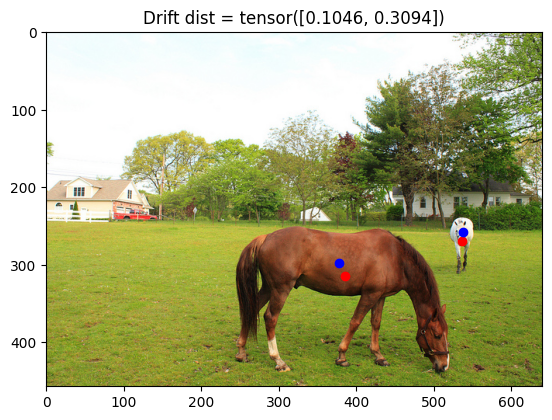

In [75]:
def estimate_centroids(img, anns):
    h, w = img['height'], img['width']
    # Get segmentations and convert them to centroids
    segmentations = [ann['segmentation'] for ann in anns]
    boxes = [obj["bbox"] for obj in anns]
    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=w)
    boxes[:, 1::2].clamp_(min=0, max=h)
    return convert_coco_poly_to_centroids(segmentations, h, w, boxes)


def compute_drift_rate(centroids, gt_centroids, gt_areas):
  distance_matrix = torch.cdist(centroids, gt_centroids)
  distances = []
  equivalent_lengths = []
  for i in range(len(centroids)):
      min_distance = torch.min(distance_matrix[i])
      min_distance_index = torch.argmin(distance_matrix[i])
      distances.append(min_distance)
      equivalent_lengths.append(np.sqrt(gt_areas[min_distance_index]))
  return torch.div(torch.Tensor(distances), torch.Tensor(equivalent_lengths))


# driver code
img_id = 144505
# img_id = 14683
# img_id = 496870
img = coco.loadImgs(img_id)[0]
img_data = Image.open(requests.get(img['coco_url'], stream=True).raw)

# Get image annotations
anns = coco.loadAnns(coco.getAnnIds(img_id))
centroids = estimate_centroids(img, anns)
gt_centroids = torch.Tensor([[378, 298],[537, 258]])
print(f'Predicted centroids: {centroids}')
plt.imshow(img_data)
for centroid in centroids:
    plt.plot(centroid[0], centroid[1], 'ro')
for centroid in gt_centroids:
    plt.plot(centroid[0], centroid[1], 'bo')
# Show image
plt.title(f'Drift dist = {compute_drift_rate(centroids, gt_centroids, [ann["area"] for ann in anns])}')
plt.show()

## Training
---

Implement all five mentioned code blocks and use the below command AS IS. You can change BS, num_epochs, num_workers. (use this output training  [log](https://drive.google.com/file/d/1ZGd-ciOKkajri0GEOwc-uJDBjGJHJdNY/view?usp=drive_link) for your reference).

Make sure checkpoints are being saved correctly and sometime not mistakenly being overriden due to multiple executions.

You can use the validation loss/loss_centroid  as a metric to track performance.

For grading:
- There are no strict limits on evaluation metrics.
- In the last cell of this notebook _avg_drift_rate_ metric is computed on a subset of validation ds. Try to score below 0.35.





In [57]:
!python -u main.py --coco_path 'hw3/coco/' --batch_size 10 --num_workers 12 --epochs 20 --output_dir './checkpoints'  --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --freeze_body # --frozen_weights './checkpoints/checkpoint.pth'

Not using distributed mode
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
git:
  sha: N/A, status: clean, branch: N/A

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
WTF is happening here False
number of params: 132869
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memor

## Visualizing
---------------

In [58]:
device = torch.device('cuda')
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



def rescale_center(out_bbox, size):
    img_w, img_h = size
    b = out_bbox * torch.tensor([img_w, img_h], dtype=torch.float32, device=device)
    return b

def detect(im, model, transform, det_threshold = 0.75):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img.to(device))

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > det_threshold

    # convert boxes from [0; 1] to image scales
    centroids = rescale_center(outputs['pred_centroids'][0, keep], im.size)
    return probas[keep].detach().cpu(), centroids.detach().cpu()

def getImg(url):
    return Image.open(requests.get(url, stream=True).raw)

def is_grayscale(image):
    if image.mode == "L":
        return True
    else:
        return False

def convert_grayscale_to_rgb(image):
    if not is_grayscale(image):
        return image
    else:
        return image.convert("RGB")


def plot_results(pil_img, prob, centroids, gt_centroids, boxes, file_name):
    # plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    ax.scatter([c[0] for c in gt_centroids], [c[1] for c in gt_centroids], color='blue', s=10)
    ax.scatter([c[0] for c in centroids], [c[1] for c in centroids.cpu()], color='red', s=10)
    if True: #show_center:
        ax.scatter([c[0]+c[2]//2 for c in boxes], [c[1]+c[3]//2 for c in boxes], color='green', s=10)
    for (xc, yc, w, h), c in zip(boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xc, yc), w, h,
                                   fill=False, color='white', linewidth=2))
    if True: #show_probs:
        for p, c in zip(prob, centroids):
            cl = p.argmax()
            text = f'- {p[cl]:0.2f}'
            ax.text(c[0] + 15, c[1], text, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    # plt.savefig(f'images/{file_name}')
    plt.show()



### before submission run below cell with display_results=True

<ipython-input-76-0ee01a59216f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/checkpoint.pth', map_location='cpu')
/usr/local/lib/p

DETR returning dict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.0.self_attn.out_proj.weight', 'transformer.encoder.layers.0.self_attn.out_proj.bias', 'transformer.encoder.layers.0.linear1.weight', 'transformer.encoder.layers.0.linear1.bias', 'transformer.encoder.layers.0.linear2.weight', 'transformer.encoder.layers.0.linear2.bias', 'transformer.encoder.layers.0.norm1.weight', 'transformer.encoder.layers.0.norm1.bias', 'transformer.encoder.layers.0.norm2.weight', 'transformer.encoder.layers.0.norm2.bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.out_proj.weight', 'transformer.encoder.layers.1.self_attn.out_proj.bias', 'transformer.encoder.layers.1.linear1.weight', 'transformer.encoder.layers.1.linear1.bias', 'transformer.encoder.layers.1.linear2.weight', 'transformer.encoder.la

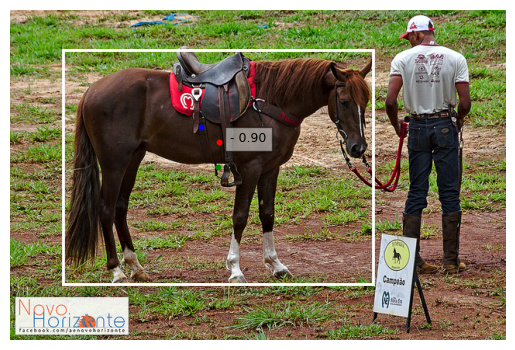

im: 350939, drift rates : [0.12445299]


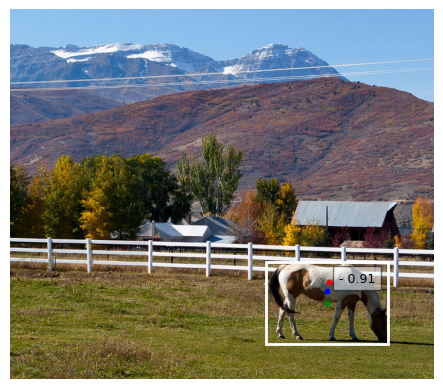

im: 158754, drift rates : [0.1185614]


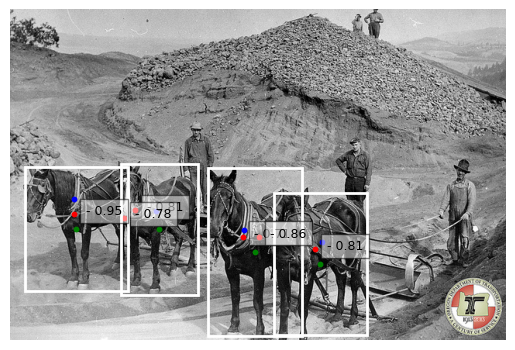

im: 501031, drift rates : [0.08721656 0.2886799  0.45141196 0.19412524 0.20710316 0.1108707 ]


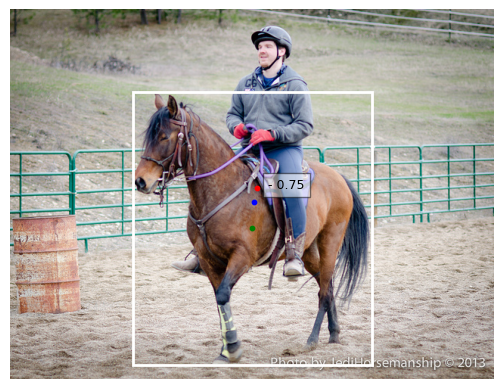

im: 178429, drift rates : [0.08912256]
Average drift rate: 0.18572714924812317


In [76]:
from models.detr import DETR
from models.backbone import build_backbone
from models.transformer import build_transformer
display_results = True

det_threshold = 0.7

checkpoint = torch.load('./checkpoints/checkpoint.pth', map_location='cpu')
args = checkpoint['args']
backbone = build_backbone(args)
transformer = build_transformer(args)
model = DETR(backbone,
             transformer,
             num_classes=2,
             num_queries=args.num_queries,
             aux_loss=args.aux_loss,
             freeze_body=args.freeze_body)

model.to(device)
print("DETR returning", {n:p for n,p in model.named_parameters()}.keys())
model.load_state_dict(checkpoint['model'])
model.eval()
if not os.path.exists('images'):
    os.mkdir('images')

coco = COCO(PATH_TO_COCO + 'annotations/instances_val2017.json')
ids = coco.getImgIds()

val_drift_rates = []
for id in range(4):
    im = coco.loadImgs(ids[id])[0]
    annos = coco.loadAnns(coco.getAnnIds(ids[id]))
    img = getImg(im['coco_url']).convert("RGB")
    scores, centroids = detect(img, model, transform, det_threshold=det_threshold)
    gt_centroids = estimate_centroids(im, annos)
    plot_results(img, scores, centroids, gt_centroids, [anno['bbox'] for anno in annos], im['file_name'])
    drift_rates = compute_drift_rate(centroids, gt_centroids, [anno['area'] for anno in annos])
    print(f'im: {ids[id]}, drift rates : {drift_rates.cpu().numpy()}')
    val_drift_rates.append(drift_rates)

overall_drit_rates = torch.concat(val_drift_rates, dim=0)
print(f'Average drift rate: {overall_drit_rates.mean()}')

## Discussion
---
**write 1 up to 3 sentences for each question**
1. ***What is your intution behind your implementation of  coco.py:convert_coco_poly_to_centroids()*** [2 points]

The polygon (all components) is converted into a mask.

The thin sections in this mask can be removed / reduced by using a min filter which will eroded the mask and make it snoother. We use a max filter to dilate mask to similar size as before.

After this we have cases of disconnected components which we need to join. We use the inverse idea of dilate first using max filter and then eroding the image again.

The filter size is setup as 1/8th of smaller dim of the bounding box through trial and error method.



2. ***Which distance metric have you used for computing the cost matrix between centroids? why?*** [1 points]

Euclidean distance / L2 loss is used for centroid.
This is so that we penalize higher errors between gt and predicted centroid coordinates.


3. ***Why freezing the entire model and traning just the heads might never actually predict the true centroids?*** [2 points]

Freezing the entire model and training only the heads might not lead to predicting the true centroids because the lower layers of the model, which typically capture fundamental features, remain unchanged and may not be optimized for the new task instead of bboxes






## Submission guidelines
---



The submission structure should look like:

IMPORTANT: Remove the _checkpoint.pth_ and make sure _heads.pth_ is in the submission.


```
{last name}_{first name}_{sbu id}_hw3/
├── part1/
│   └── ...
├── part2/
│   ├── hw3_part2.ipynb
│   └── detr/
│       ├── checkpoints/
│       │   └── heads.pth
│       ├── datasets/
│       │   ├── coco.py
│       │   ├── ...
│       │   └── ...
│       ├── models/
│       │   ├── detr.py
│       │   ├── matcher.py
│       │   ├── ...
│       │   └── ...
│       ├── utils/
│       │   ├── ...
│       │   └── ...
│       ├── engine.py
│       ├── main.py
│       ├── hubconf.py
│       └── requirements.txt
```


Follow instructions in part1's submission guidelines to generate your complete submission